In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier

%matplotlib inline

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data
    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append(
            (f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i]))
        )
    return pd.Series(data=out_col, index=mean_scores.index)

In [3]:
with open("data/processed/training_data.pickle", "rb") as f:
    training_data = pickle.load(f)

with open("data/processed/training_arm.pickle", "rb") as f:
    training_arm = pickle.load(f)
    
with open("data/processed/mean_trajectory.pickle", "rb") as f:
    mean_trajectory = pickle.load(f)

In [4]:
print(training_data.shape)
print(training_arm.shape)

(40000, 298)
(40000, 3000)


In [5]:
data = np.concatenate((training_data, training_arm), axis=1)
data.shape

(40000, 3298)

In [6]:
X_train, X_test, y_train_arm, y_test_arm = train_test_split(
    data[:, :297], data[:, 297:],
    test_size=0.3, random_state=2022
)

y_train = y_train_arm[:, 0]
y_test = y_test_arm[:, 0]

arm_train = y_train_arm[:, 1:]
arm_test = y_test_arm[:, 1:]

print(X_train.shape)
print(y_train.shape)
print(arm_train.shape)

(28000, 297)
(28000,)
(28000, 3000)


In [7]:
lr_pipe = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(LogisticRegression(max_iter=2000))
)

results_lr = mean_std_cross_val_scores(
    lr_pipe, X_train, y_train, return_train_score=True
)

pd.DataFrame(results_lr)

,0
fit_time,4.539 (+/- 0.214)
score_time,0.053 (+/- 0.006)
test_score,0.978 (+/- 0.001)
train_score,0.995 (+/- 0.000)


In [8]:
lr_pipe.fit(X_train, y_train)
print(lr_pipe.score(X_train, y_train))
print(lr_pipe.score(X_test, y_test))

0.9934642857142857
0.9805


In [9]:
predictions = lr_pipe.predict(X_test)
predictions.shape

(12000,)

In [13]:
RMSE = 0
for idx, i in enumerate(predictions):
    predicted_trajectory = mean_trajectory[f"dir_{int(i)}"]
    actual_trajectory = arm_test[idx, :]
    RMSE = (RMSE + 
            (1 / predictions.shape[0]) * 
            np.sqrt(np.mean(
                (actual_trajectory - predicted_trajectory)**2))
           )

print(f"RMSE = {RMSE}")
print(f"Accuracy = {100 * sum(predictions == y_test) / y_test.shape[0]}")

RMSE = 53.08746124272516
Accuracy = 98.05


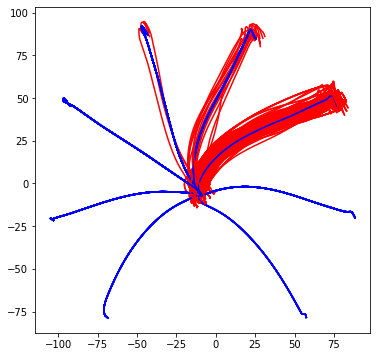

11766


In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
for i in range(predictions.shape[0]):
    if not(int(predictions[i]) == y_test[i]):
        predicted_trajectory = mean_trajectory[f"dir_{int(predictions[i])}"]
        actual_trajectory = arm_test[i, :]
        ax.plot(actual_trajectory[:1000], actual_trajectory[1000:2000],
                color="r", label=f"A{i}")
        ax.plot(predicted_trajectory[:1000], predicted_trajectory[1000:2000],
                color="b", label=f"P{i}")
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

print(sum(predictions == y_test))